# Evaluate Separation Quality

## Evaluate by Listening

In [2]:
import nussl
import matplotlib.pyplot as plt
import time
import torch
import json

import warnings
warnings.filterwarnings("ignore")

### Listen to room (the state) at beginning of episode

In [3]:
# new0-1 is new state in episode 0, step 1
room_sound_path = '../data/new_states/new2-1.wav'
room_sound = nussl.AudioSignal(room_sound_path)
room_sound.embed_audio(display=False)

Then select the right model (usually the latest episode) from the correct experiment folder.

In [112]:
# 12 and 15 seem to be best
model_path = '../models/test-exp-5-50eps_test_simp_env_validation/sp_ep12.pt'

# around 15 or 30 seems to be best rn
# model_path = '../models/test-exp-5-50eps_test_simp_env_validation-2/sp_ep30.pt'

#model_path = '../models/test-exp-5-50eps_test_simp_env_validation-3/sp_ep38.pt'

# final run: ep 10 is not bad
#model_path = '../models/exp5-200eps-final-run/sp_ep10.pt'

Then put the mix through the model to hear the result.

Matching file found at /home/ubuntu/.nussl/audio/wsj_speech_mixture_ViCfBJj.mp3, skipping download.
STFTParams(window_length=256, hop_length=64, window_type='sqrt_hann')
SeparationModel(
  (layers): ModuleDict(
    (audio): STFT()
    (concatenate): Concatenate()
    (estimates): Mask()
    (expand): Expand()
    (log_spectrogram): AmplitudeToDB()
    (mask): Embedding(
      (linear): Linear(in_features=100, out_features=258, bias=True)
    )
    (normalization): BatchNorm(
      (batch_norm): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (recurrent_stack): RecurrentStack(
      (rnn): LSTM(129, 50, batch_first=True, dropout=0.3, bidirectional=True)
    )
    (split): Split()
  )
)
Number of parameters: 98460
[<nussl.core.audio_signal.AudioSignal object at 0x7f0a191dfe50>, <nussl.core.audio_signal.AudioSignal object at 0x7f0a191dfd50>]


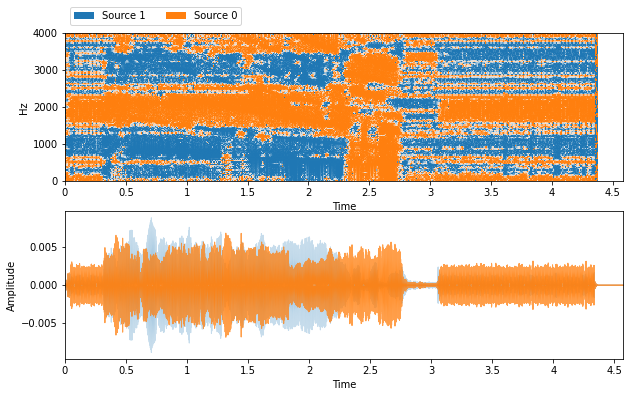


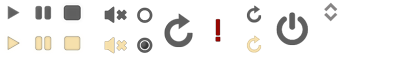
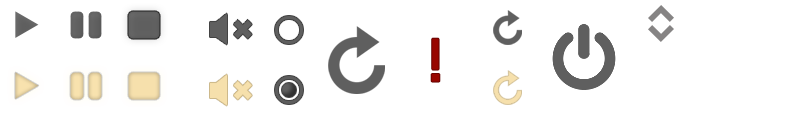
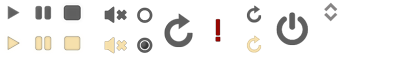

In [113]:
start_time = time.time()

def visualize_and_embed(sources):
    plt.figure(figsize=(10, 6))
    plt.subplot(211)
    nussl.utils.visualize_sources_as_masks(sources,
        y_axis='linear', db_cutoff=-80, alpha_amount=2.0)
    plt.subplot(212)
    nussl.utils.visualize_sources_as_waveform(
        sources, show_legend=False)
    plt.show()
    nussl.play_utils.multitrack(sources)

audio_path = nussl.efz_utils.download_audio_file(
    'wsj_speech_mixture_ViCfBJj.mp3')

# for testing on new data
audio_files = [
    '../sounds/dry_recordings/dev/050/050a0501.wav',
    '../sounds/dry_recordings/dev/051/051a0502.wav'
]
# audio_files = [
#      '../sounds/phone/cellphone_ringing.wav',
#      '../sounds/siren/siren.wav'
#  ]
signals = []
gains = [1, 1]

for i, a in enumerate(audio_files):
    sig = nussl.AudioSignal(a)
    signals.append(sig * gains[i])
    
min_length = min([x.signal_duration for x in signals])
[x.truncate_seconds(min_length) for x in signals]
audio_signal = sum(signals)

separator = nussl.separation.deep.DeepAudioEstimation(
    room_sound, model_path=None)

model_dict = torch.load(model_path)
model = nussl.ml.SeparationModel(model_dict['config'])
model.load_state_dict(model_dict['state_dict'])
print(audio_signal.stft_params)
separator.model = model
print(separator.model)
separator.metadata = {
    'sample_rate': model_dict['sample_rate'],
    'stft_params': audio_signal.stft_params,
    'num_channels': 1
}
separator.transform = nussl.datasets.transforms.Compose([
    nussl.datasets.transforms.GetAudio(),
    nussl.datasets.transforms.ToSeparationModel(),
])
separator.device = 'cpu'

otoworld_estimates = separator()
print(otoworld_estimates)
ibm = nussl.separation.benchmark.IdealBinaryMask(
    room_sound, otoworld_estimates, 
)
otoworld_estimates = ibm()

otoworld_estimates = {
    f'Source {i}': e for i, e in enumerate(otoworld_estimates)
}

visualize_and_embed(otoworld_estimates)

#### Predicted Sources are downloadable

In [6]:
otoworld_estimates['Source 0'].embed_audio(display=False)

In [7]:
otoworld_estimates['Source 1'].embed_audio(display=False)

### Inspect the Mask

In [114]:
separator.model_output['mask'].mean(dim=[0, 1, 2, 3])

tensor([0.5273, 0.4727])

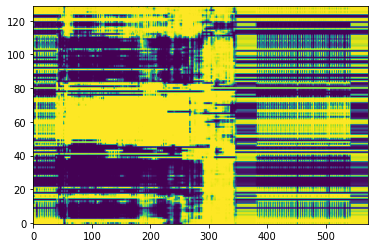

In [115]:
# spectrogram is multiplied by the mask to separate sources 
plt.imshow(separator.model_output['mask'][0, ..., 0, 0].cpu().data.numpy().T, 
           origin='lower', aspect='auto', vmin=0.0, vmax=1.0)

In [10]:
separator.model_output['mask'][0, 0, 0]

tensor([[1.6364e-05, 9.9998e-01]])

## Compare to Separation using Spatial Clustering

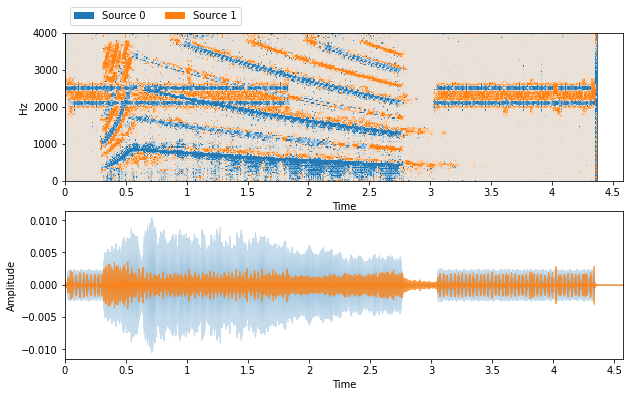


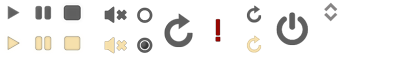
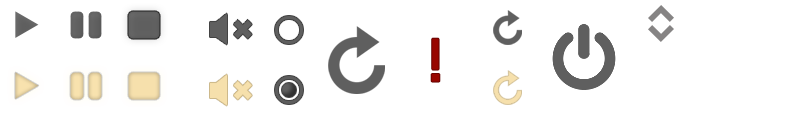
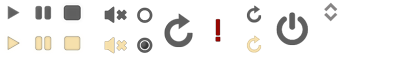

In [11]:
spcl = nussl.separation.spatial.SpatialClustering(
    room_sound, num_sources=2, mask_type='binary'
)
clustering_estimates = spcl()

clustering_estimates = {
    f'Source {i}': e for i, e in enumerate(clustering_estimates)
}

visualize_and_embed(clustering_estimates)

## Evaluate with Metrics
Specifically, using SDR (source-to-distortion) ratio

In [116]:
# from listening, it seems source 0 is the phone ringing 
# and source 1 is the car horn
otoworld_estimates

{'Source 0': <nussl.core.audio_signal.AudioSignal at 0x7f0a191df750>,
 'Source 1': <nussl.core.audio_signal.AudioSignal at 0x7f0a191dfbd0>}

#### Load ground truth sources - need to re-create env
Ground truth: agent and sources at their initial locations in the room, computer the RIR with only one source turned on and that will represent the ground truth for that source. Do the same for the other source.

In [117]:
# just copying experiment5.py code for now to replicate env
import sys
sys.path.append("../src/")
from datetime import datetime
import os

import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import logging
from torch.utils.tensorboard import SummaryWriter

import room_types
import agent
import audio_room
import utils
import constants
import nussl
from datasets import BufferData
import time
import audio_processing
from models import RnnAgent
import transforms

In [118]:
# Shoebox Room
nussl.utils.seed(7)
room = room_types.ShoeBox(x_length=8, y_length=8)

source_folders_dict = {'../sounds/phone/': 1,
                        '../sounds/siren/': 1}

# Set up the gym environment
env = gym.make(
    "audio-room-v0",
    room_config=room.generate(),
    source_folders_dict=source_folders_dict,
    corners=room.corners,
    max_order=10,
    step_size=1.0,
    acceptable_radius=1.0,
    absorption=1.0,
    reset_sources=False,
    same_config=True
)
env.seed(7)

# fixing lengths
tfm = transforms.Compose([
    transforms.GetAudio(mix_key=['prev_state', 'new_state']),
    transforms.ToSeparationModel(),
    transforms.GetExcerpt(excerpt_length=32000,
                          tf_keys=['mix_audio_prev_state'], time_dim=1),
    transforms.GetExcerpt(excerpt_length=32000,
                          tf_keys=['mix_audio_new_state'], time_dim=1)
])

# create dataset object (subclass of nussl.datasets.BaseDataset)
dataset = BufferData(
    folder=constants.DIR_DATASET_ITEMS,
    to_disk=True,
    transform=tfm
)

# create agent obj (same env config as the training to get ground truth)
agent.RandomAgent(env=env, dataset=dataset, episodes=1, max_steps=2)

Source locs [[5.65761384716134, 5.871071402613153], [0.8211730703874749, 3.0]]
Min size audio: inf
Min size audio: 43070
Placing agent at [3.7420228779598457, 1.6387927223823606]


In [119]:
# source 0 and source 1
print(env.direct_sources)
print(env.source_locs)

['../sounds/phone/cellphone_ringing.wav', '../sounds/siren/siren.wav']
[[5.65761384716134, 5.871071402613153], [0.8211730703874749, 3.0]]


In [120]:
print(len(env.room.sources[0].signal))
print(len(env.room.sources[1].signal))

34523
34523


Get ground truth for source 0

In [121]:
ground_truth_sources = []

In [122]:
# remove src 1 to get ground truth for src 0
env._remove_source(index=1)
print(env.direct_sources)
print(env.source_locs)

['../sounds/phone/cellphone_ringing.wav']
[[5.65761384716134, 5.871071402613153]]


In [123]:
print(len(env.room.sources[0].signal))

34523


In [124]:
# get ground truth for src 0
env.room.compute_rir()
env.room.simulate()
ground_truth0_np = env.room.mic_array.signals
print(ground_truth0_np.shape)

# convert to nussl AudioSignal
ground_truth0 = nussl.AudioSignal(audio_data_array=ground_truth0_np, sample_rate=env.resample_rate)
ground_truth0.embed_audio(display=False)

(2, 36570)


In [125]:
print(len(ground_truth0))
ground_truth_sources.append(ground_truth0)

36570


Get ground truth for source 1

In [126]:
# add back src 1
env.reset(removing_source=0)

print(env.direct_sources)
print(env.source_locs)

Source locs [[5.65761384716134, 5.871071402613153], [0.8211730703874749, 3.0]]
Min size audio: inf
Min size audio: 43070
Placing agent at [3.7420228779598457, 1.6387927223823606]
['../sounds/phone/cellphone_ringing.wav', '../sounds/siren/siren.wav']
[[5.65761384716134, 5.871071402613153], [0.8211730703874749, 3.0]]


In [127]:
print(len(env.room.sources[0].signal))
print(len(env.room.sources[1].signal))

34523
34523


In [128]:
# remove src 0
env._remove_source(index=0)
print(env.direct_sources)
print(env.source_locs)

['../sounds/siren/siren.wav']
[[0.8211730703874749, 3.0]]


In [129]:
print(len(env.room.sources[0].signal))

34523


In [130]:
# get ground truth for src 1
env.room.compute_rir()
env.room.simulate()
ground_truth1 = env.room.mic_array.signals

# pad with zeros to match length of src 0 before converting to AudioSignal
ground_truth1_np = np.zeros(ground_truth0_np.shape)
ground_truth1_np[:ground_truth1.shape[0], :ground_truth1.shape[1]] = ground_truth1

ground_truth1_np.shape

(2, 36570)

In [131]:
# convert to nussl AudioSignal
ground_truth1 = nussl.AudioSignal(audio_data_array=ground_truth1_np, sample_rate=env.resample_rate)
ground_truth1.embed_audio(display=False)

In [132]:
print(len(ground_truth1))
ground_truth_sources.append(ground_truth1)

36570


In [133]:
print(len(ground_truth_sources[0]))
print(len(ground_truth_sources[1]))

36570
36570


In [134]:
print(ground_truth_sources[0].signal_duration, ground_truth_sources[1].signal_duration)

4.57125 4.57125


In [135]:
print(otoworld_estimates['Source 0'].signal_duration, otoworld_estimates['Source 1'].signal_duration)

4.57125 4.57125


In [136]:
otoworld_estimates['Source 1'].embed_audio(display=False)

In [137]:
_gt = [x.to_mono() for x in ground_truth_sources]
_est = [x.to_mono() for x in list(otoworld_estimates.values())]
new_bss = nussl.evaluation.BSSEvalScale(
    true_sources_list=_gt,
    estimated_sources_list=_est,
    compute_permutation=True 
)
scores = new_bss.evaluate()

print(json.dumps(scores, indent=2))

{
  "combination": [
    0,
    1
  ],
  "permutation": [
    0,
    1
  ],
  "source_0": {
    "SI-SDR": [
      -1.3848633051075394
    ],
    "SI-SIR": [
      11.250965518890489
    ],
    "SI-SAR": [
      -1.1414667536464416
    ],
    "SD-SDR": [
      -5.001888124094499
    ],
    "SNR": [
      -14.44445054042993
    ],
    "SRR": [
      -2.52384824523043
    ],
    "SI-SDRi": [
      11.024431017900788
    ],
    "SD-SDRi": [
      7.407454782219366
    ],
    "SNRi": [
      -2.1555053347620206
    ],
    "MIX-SI-SDR": [
      -12.409294323008327
    ],
    "MIX-SD-SDR": [
      -12.409342906313865
    ],
    "MIX-SNR": [
      -12.28894520566791
    ]
  },
  "source_1": {
    "SI-SDR": [
      -2.4306942071521536
    ],
    "SI-SIR": [
      27.254724992393506
    ],
    "SI-SAR": [
      -2.4260224962897237
    ],
    "SD-SDR": [
      -2.755715092765205
    ],
    "SNR": [
      -0.029004223885305602
    ],
    "SRR": [
      8.664512309473695
    ],
    "SI-SDRi": [
   